# Выбор локации для скважины

Задача: решить, где бурить новую скважину для добывающей компании.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо посмтроить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. И проанализировать возможную прибыль и риски техникой *Bootstrap.*


Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Были получены датасеты по 3 регионам для определения лучшего (прибыльного) с точки зрения разработки в нем скважин. Необходимо будет просмотреть общкю информацию о данных, при необходимости предобработать. Построить модель для предсказания объемов запасов нефти и просчитать наиболее прибыльный регион.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 11111

In [2]:
first_region = pd.read_csv('/datasets/geo_data_0.csv')
second_region = pd.read_csv('/datasets/geo_data_1.csv')
third_region = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
first_region.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
first_region.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
second_region.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
second_region.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [7]:
third_region.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
third_region.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


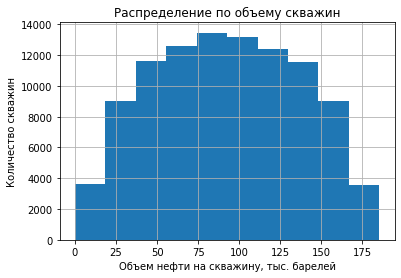

In [9]:
first_region['product'].hist()
plt.xlabel("Объем нефти на скважину, тыс. барелей")
plt.ylabel("Количество скважин")
plt.title("Распределение по объему скважин")
plt.show()

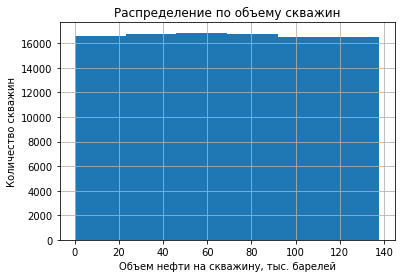

In [10]:
second_region['product'].hist(bins=6)
plt.xlabel("Объем нефти на скважину, тыс. барелей")
plt.ylabel("Количество скважин")
plt.title("Распределение по объему скважин")
plt.show()

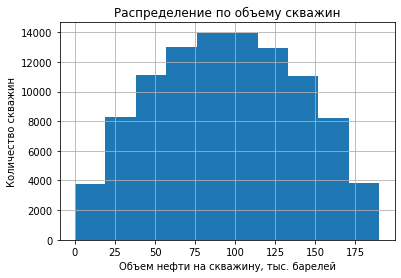

In [11]:
third_region['product'].hist()
plt.xlabel("Объем нефти на скважину, тыс. барелей")
plt.ylabel("Количество скважин")
plt.title("Распределение по объему скважин")
plt.show()

Первый и третий регионы похожи в части распределения объемов нефти- они распределены нормально. Второй регион отличается- в нем все данные распределены равномерно ( в том числе и нулевых значений тоже около 8тыс)

## Обучение и проверка модели

Так как получать предсказания модели нужно по трем регионам: напишем функцию по разделению выборок. Затем обучим модель на неподготовленных данных, проверим метрикой. Далее масштабируем данные и проверим функцию еще раз

In [12]:
def data_split(data):
    features = data[['f0', 'f1', 'f2']]
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)
    
    return features_train, features_valid, target_train, target_valid

In [13]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = data_split(first_region)

In [14]:
features_train_1.shape

(75000, 3)

In [15]:
features_valid_1.shape

(25000, 3)

In [16]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
model_1_predict = model_1.predict(features_valid_1)
rmse_1 = mean_squared_error(target_valid_1, model_1_predict)**0.5
print('RMSE 1 региона =', rmse_1)

RMSE 1 региона = 37.80134678944078


RMSE 1 региона = 37.80134678944078

При масштабировании показатель rmse не изменился

Посмотрим на 2 регион

In [17]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = data_split(second_region)

Без масштабирования:

In [18]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
model_2_predict = model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, model_2_predict)**0.5
print('RMSE 2 региона без масштабирования =', rmse_2)

RMSE 2 региона без масштабирования = 0.8928812144337774


RMSE 2 региона = 0.8928812144337774


Так же масштабирование никак не повлияло

И очень хороший показатель rmse, а данные у нас во втором регионе были распределены равномерно.

Посмотрим на оставшийся 3 регион

In [19]:
features_train_3, features_valid_3, target_train_3, target_valid_3 = data_split(third_region)

In [20]:
model_3 = LinearRegression()
model_3.fit(features_train_3, target_train_3)
model_3_predict = model_3.predict(features_valid_3)
rmse_3 = mean_squared_error(target_valid_3, model_3_predict)**0.5
print('RMSE 3 региона без масштабирования =', rmse_3)

RMSE 3 региона без масштабирования = 40.2343226993647


Так же масштабирование не дало результатов.

Объединю объем реального объема нефти в точке с предсказанным для удобства

In [21]:
data_first = {'real_product': target_valid_1, 'predicted_product': model_1_predict}
df_first = pd.DataFrame(data_first)

In [22]:
data_second = {'real_product': target_valid_2, 'predicted_product': model_2_predict}
df_second = pd.DataFrame(data_second)

In [23]:
data_third = {'real_product': target_valid_3, 'predicted_product': model_3_predict}
df_third = pd.DataFrame(data_third)

In [24]:
# сохраню значения в константы, чтобы при дальнейших подсчетах не рассчитывать заново
first_region_product_mean = first_region["product"].mean().round(5)
first_region_product_predict = model_1_predict.mean().round(5)

print(f'Средний объем нефти в первом регионе: {first_region_product_mean}')
print(f'Предсказанный средний объем нефти в первом регионе: {first_region_product_predict}')
print('RMSE 3 региона =', rmse_1)

Средний объем нефти в первом регионе: 92.5
Предсказанный средний объем нефти в первом регионе: 92.60219
RMSE 3 региона = 37.80134678944078


In [25]:
second_region_product_mean = second_region["product"].mean().round(5)
second_region_product_predict = model_2_predict.mean().round(5)

print(f'Средний объем нефти во втором регионе: {second_region_product_mean}')
print(f'Предсказанный средний объем нефти во втором регионе: {second_region_product_predict}')
print('RMSE 3 региона =', rmse_2)

Средний объем нефти во втором регионе: 68.825
Предсказанный средний объем нефти во втором регионе: 69.42023
RMSE 3 региона = 0.8928812144337774


In [26]:
third_region_product_mean = third_region["product"].mean().round(5)
third_region_product_predict = model_3_predict.mean().round(5)

print(f'Средний объем нефти в третьем регионе: {third_region_product_mean}')
print(f'Предсказанный средний объем нефти в третьем регионе: {third_region_product_predict}')
print('RMSE 3 региона =', rmse_3)

Средний объем нефти в третьем регионе: 95.0
Предсказанный средний объем нефти в третьем регионе: 94.93496
RMSE 3 региона = 40.2343226993647


### Вывод:
Лучшая метрика rmse у 2 региона (0.89), далее первый (37.8) и третий (40.2)
Средний объем нефти и предсказанный средний объем во всех трех регионах практически равны. Но так как в 1 и 3 регионах средняя квадратичная ошибка выше- значит, предсказания там имеют больший разброс.



## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним полученный объём сырья со средним запасом в каждом регионе. 

In [27]:
BUDGET = 10**7 # бюджет на разработку скважин (в тыс. руб.)
REGION_POINTS = 500 # количество точек, исследуемых при разведке
BEST_POINTS = 200 # количество лучших точек
PRICE_1_BARREL = 450 # доход с 1 баррели нефти

In [28]:
print('Для безубыточной разработки скважин в регионе:')
mean_profit_per_point = (BUDGET / BEST_POINTS)
print(f'Необходимая средняя прибыль на точку - {mean_profit_per_point} тыс. руб.')

mean_barrels_per_point = mean_profit_per_point  / PRICE_1_BARREL
print(f'Необходимый средний запас нефти на точку - {round(mean_barrels_per_point, 3)} тыс. баррелей')

mean_barrels_reg = BUDGET / PRICE_1_BARREL
print(f'Необходимый средний запас нефти на регион - {round(mean_barrels_reg, 3)} тыс. баррелей')

Для безубыточной разработки скважин в регионе:
Необходимая средняя прибыль на точку - 50000.0 тыс. руб.
Необходимый средний запас нефти на точку - 111.111 тыс. баррелей
Необходимый средний запас нефти на регион - 22222.222 тыс. баррелей


Далее напишем функцию по выбору лучших точек и подсчету прибыли по ним

In [29]:
def oil_profit_calc(target, probs, count):
    probs_sorted = probs.sort_values(ascending=False)
    target_sort = target[probs_sorted.index][:count]
    return (PRICE_1_BARREL * target_sort.sum() - BUDGET), target_sort.mean()

## Расчёт прибыли и рисков 

Напишем функцию для бутстрепа по расчету прибыльности региона и среднему количеству запасов нефти в точках:

In [30]:
state = np.random.RandomState(RANDOM_STATE)
def bootstrap(target, probs):
    values=[]
    oil_values = []
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=REGION_POINTS)
        probs_sample = probs[target_sample.index]
        profit, oil = oil_profit_calc(target, probs_sample, BEST_POINTS)
        oil_values.append(oil)    
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025).round(3)
    upper = values.quantile(0.975).round(3)
    mean = values.mean().round(3)
    risk = ((values < 0).mean() * 100).round(3)
    oil_mean = pd.Series(oil_values).mean()
    
    return mean, lower, upper, risk, oil_mean

In [31]:
mean_1, lower_1, upper_1, risk_1, oil_mean_1 = bootstrap(df_first['real_product'], df_first['predicted_product'])
print('Данные по первому региону:')
print(f'Средняя прибыль по региону = {mean_1} тыс.руб.')
print(f'Средний запас нефти в скважине {oil_mean_1}')
print(f'95% доверительный интервал от {lower_1} до {upper_1} тыс.руб.')
print(f'Процент риска {risk_1}%')

Данные по первому региону:
Средняя прибыль по региону = 469536.505 тыс.руб.
Средний запас нефти в скважине 116.32818338968403
95% доверительный интервал от -59949.482 до 989980.787 тыс.руб.
Процент риска 4.8%


In [32]:
mean_2, lower_2, upper_2, risk_2, oil_mean_2 = bootstrap(df_second['real_product'], df_second['predicted_product'])
print('Данные по первому региону:')
print(f'Средняя прибыль по региону = {mean_2} тыс.руб.')
print(f'Средний запас нефти в скважине {oil_mean_2}')
print(f'95% доверительный интервал от {lower_2} до {upper_2} тыс.руб.')
print(f'Процент риска {risk_2}%')

Данные по первому региону:
Средняя прибыль по региону = 509111.391 тыс.руб.
Средний запас нефти в скважине 116.76790434485554
95% доверительный интервал от 77340.178 до 940053.418 тыс.руб.
Процент риска 1.1%


In [33]:
mean_3, lower_3, upper_3, risk_3, oil_mean_3 = bootstrap(df_third['real_product'], df_third['predicted_product'])
print('Данные по первому региону:')
print(f'Средняя прибыль по региону = {mean_3} тыс.руб.')
print(f'Средний запас нефти в скважине {oil_mean_3}')
print(f'95% доверительный интервал от {lower_3} до {upper_3} тыс.руб.')
print(f'Процент риска {risk_3}%')


Данные по первому региону:
Средняя прибыль по региону = 393044.162 тыс.руб.
Средний запас нефти в скважине 115.4782684630756
95% доверительный интервал от -154136.901 до 917412.777 тыс.руб.
Процент риска 7.7%


После изучения трех регионов - разработка скважин во 2 регионе наименее рискованная (порядка 1% риск). Так же средний запас нефти и доверительный интервал устраивают условию поставленной задачи. При этом в данном регионе объем нефти от 0 до 140 тыс. баррелей распределен равномерно между точками, то есть количество пустых точек велико.

В первом и третьем процент риска выше, и доверительный интервал захватыват отрицательные значения (то есть теоретические убытки)


Итог: 2 регион предпочтителен для разработки